In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/flowers-dataset/sample_submission.csv
/kaggle/input/flowers-dataset/Testing_set_flower.csv
/kaggle/input/flowers-dataset/LICENSE.txt
/kaggle/input/flowers-dataset/test/Image_747.jpg
/kaggle/input/flowers-dataset/test/Image_561.jpg
/kaggle/input/flowers-dataset/test/Image_345.jpg
/kaggle/input/flowers-dataset/test/Image_844.jpg
/kaggle/input/flowers-dataset/test/Image_270.jpg
/kaggle/input/flowers-dataset/test/Image_526.jpg
/kaggle/input/flowers-dataset/test/Image_322.jpg
/kaggle/input/flowers-dataset/test/Image_860.jpg
/kaggle/input/flowers-dataset/test/Image_574.jpg
/kaggle/input/flowers-dataset/test/Image_879.jpg
/kaggle/input/flowers-dataset/test/Image_22.jpg
/kaggle/input/flowers-dataset/test/Image_486.jpg
/kaggle/input/flowers-dataset/test/Image_608.jpg
/kaggle/input/flowers-dataset/test/Image_592.jpg
/kaggle/input/flowers-dataset/test/Image_352.jpg
/kaggle/input/flowers-dataset/test/Image_687.jpg
/kaggle/input/flowers-dataset/test/Image_278.jpg
/kaggle/input/flowers

In [11]:
from skimage import io
import os
import glob
import numpy as np
import matplotlib.pyplot as plt
import random
import keras
%matplotlib inline

In [3]:
# function to plot n images using subplots
def plot_image(images, captions=None, cmap=None ):
    f, axes = plt.subplots(1, len(images), sharey=True)
    f.set_figwidth(15)
    for ax,image in zip(axes, images):
        ax.imshow(image, cmap)

In [8]:
DATASET_PATH = '/kaggle/input/flowers-dataset/train/'
flowers_cls = ['daisy', 'rose']

/kaggle/input/flowers-dataset/train/daisy/*
/kaggle/input/flowers-dataset/train/daisy/9146733107_98b15d3892_m.jpg


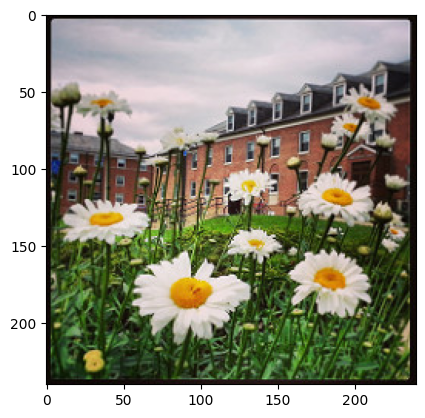

In [12]:
# globbing example
# help(glob)
flower_path = os.path.join(DATASET_PATH, flowers_cls[0], '*')
print(flower_path)

# glob through the directory (returns a list of all file paths)
flower_path = glob.glob(flower_path)
print(flower_path[3]) # access an individual file

image = io.imread(flower_path[3])
plt.imshow(image)

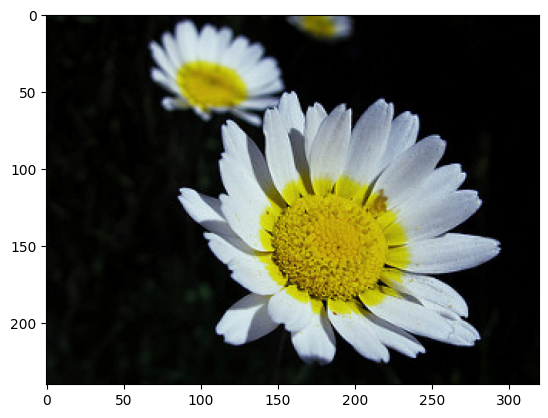

In [14]:
# run this block multiple times to look at some randomly chosen images of daisies
rand_index = random.randint(0, len(flower_path))
image = io.imread(flower_path[rand_index])
plt.imshow(image)

In [15]:
print(image.shape)

(240, 320, 3)


### Augmentation and Preprocessing

Text(0.5, 0.98, 'Different Channels of Image')

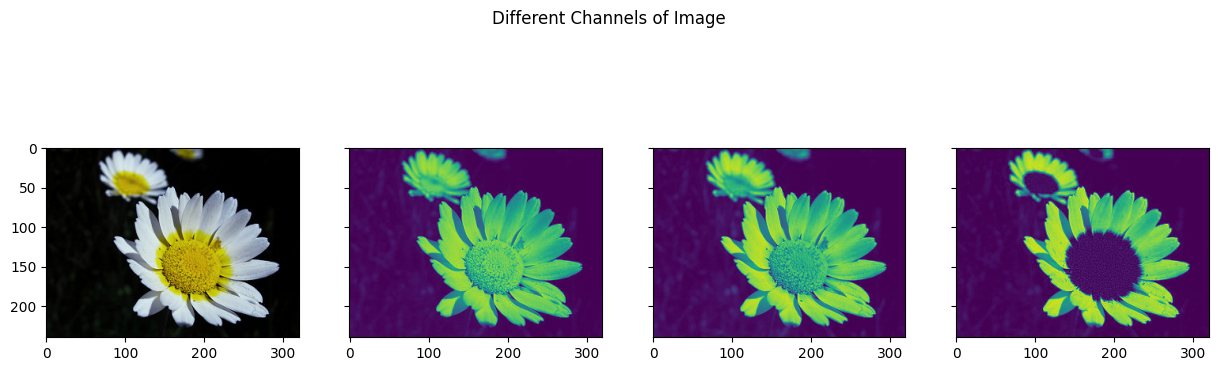

In [16]:
# plotting the original image and the RGB channels
f, (ax1, ax2, ax3, ax4) = plt.subplots(1, 4, sharey=True)
f.set_figwidth(15)
ax1.imshow(image)

# RGB channels
ax2.imshow(image[:, : , 0]) # 0 refers to channel id for red
ax3.imshow(image[:, : , 1]) # 1 refers to channel id for green
ax4.imshow(image[:, : , 2]) # 2 refers to channel id for blue
f.suptitle('Different Channels of Image')

### Important pre processing step is to bring all the images to the same shape as not all the images in real world will be of the same shape

### Morphological Transformations

### Thresholding
One of the simpler operations where we take all the pixels whose intensities are above a certain threshold, and convert them to ones; the pixels having value less than the threshold are converted to zero. This results in a binary image.

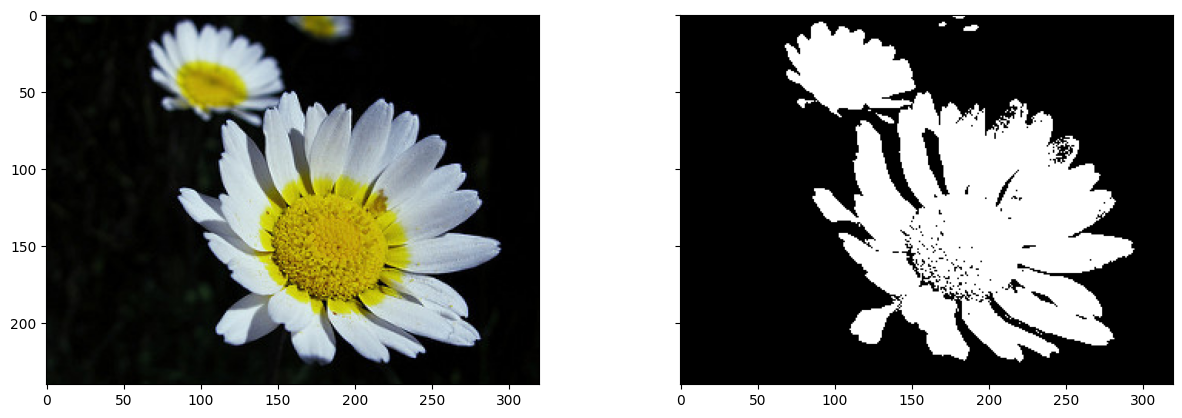

In [17]:
# bin_image will be a (240, 320) True/False array
bin_image = image[:, :, 0] > 125
plot_image([image, bin_image], cmap='gray')

### Erosion, Dilation, Opening & Closing
#### Erosion shrinks bright regions and enlarges dark regions. Dilation on the other hand is exact opposite side - it shrinks dark regions and enlarges the bright regions.

#### Opening is erosion followed by dilation. Opening can remove small bright spots (i.e. “salt”) and connect small dark cracks. This tends to “open” up (dark) gaps between (bright) features.

#### Closing is dilation followed by erosion. Closing can remove small dark spots (i.e. “pepper”) and connect small bright cracks. This tends to “close” up (dark) gaps between (bright) features.

All these can be done using the skimage.morphology module. The basic idea is to have a circular disk of a certain size (3 below) move around the image and apply these transformations using it.

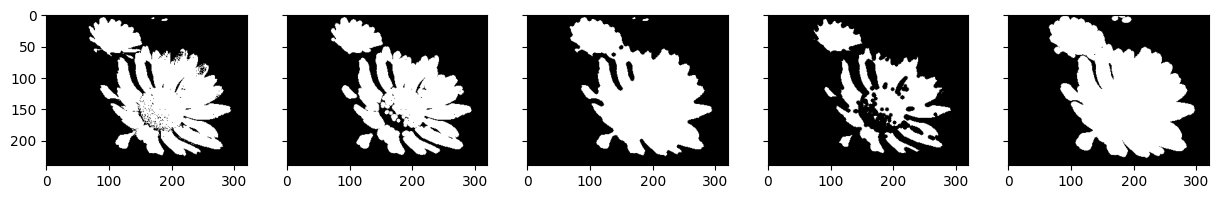

In [22]:
from skimage.morphology import binary_closing, binary_dilation, binary_erosion, binary_opening
from skimage.morphology import disk

# use a disk of radius 3
selem = disk(3)

# oprning and closing
open_img = binary_opening(bin_image, selem)
close_img = binary_closing(bin_image, selem)

# erosion and dilation
eroded_img = binary_erosion(bin_image, selem)
dilated_img = binary_dilation(bin_image, selem)

plot_image([bin_image, open_img, close_img, eroded_img, dilated_img], cmap='gray')

### Normalisation

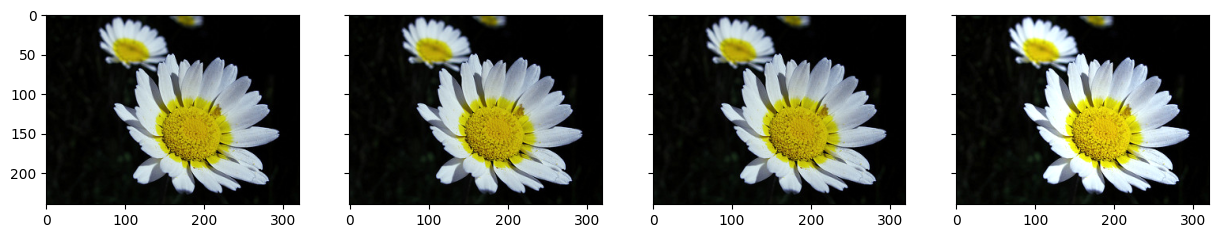

In [23]:
norm1_image = image/255
norm2_image = (image - np.min(image))/(np.max(image) - np.min(image))
norm3_image = (image - np.percentile(image,5))/ (np.percentile(image,95) - np.percentile(image,5))

plot_image([image, norm1_image, norm2_image, norm3_image], cmap='gray')

### Augmentation
1. Linear Transformations
2. Affine Transformations

Either training data is absolutely small or we want to tackle overfitting

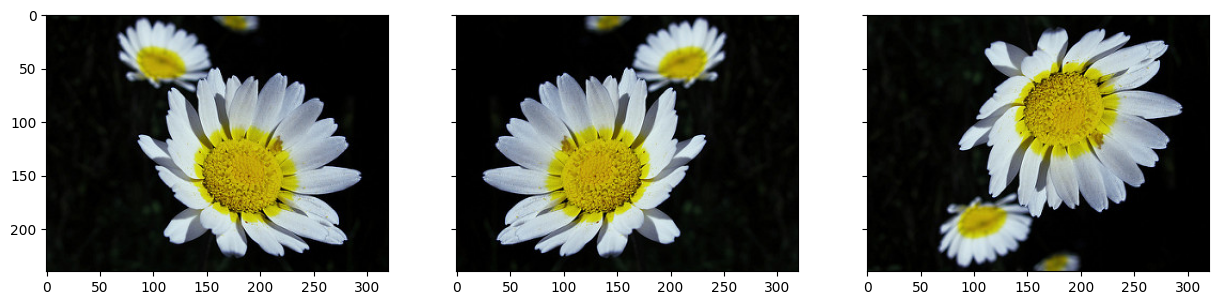

In [24]:
from skimage import transform

# flip left-right, up-down
image_flipr = np.fliplr(image)
image_flipud = np.flipud(image)

plot_image([image, image_flipr, image_flipud])

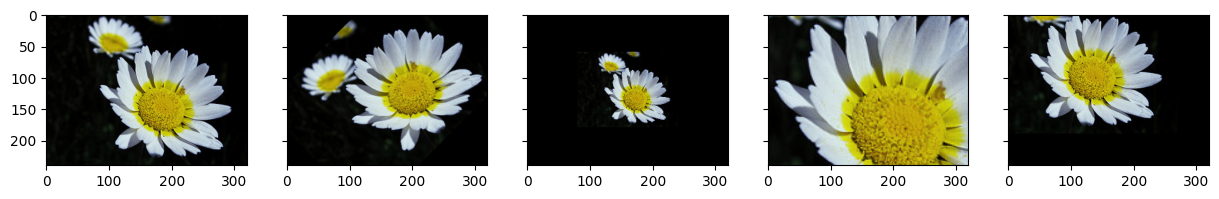

In [25]:
# specify x and y coordinates to be used for shifting (mid points)
shift_x, shift_y = image.shape[1]/2, image.shape[0]/2

# translation by certain units
matrix_to_topleft = transform.SimilarityTransform(translation=[-shift_x, -shift_y])
matrix_to_center = transform.SimilarityTransform(translation=[shift_x, shift_y])

# rotation
rot_transforms =  transform.AffineTransform(rotation=np.deg2rad(45))
rot_matrix = matrix_to_topleft + rot_transforms + matrix_to_center
rot_image = transform.warp(image, rot_matrix)

# scaling
scale_transforms = transform.AffineTransform(scale=(2, 2))
scale_matrix = matrix_to_topleft + scale_transforms + matrix_to_center
scale_image_zoom_out = transform.warp(image, scale_matrix)

scale_transforms = transform.AffineTransform(scale=(0.5, 0.5))
scale_matrix = matrix_to_topleft + scale_transforms + matrix_to_center
scale_image_zoom_in = transform.warp(image, scale_matrix)

# translation
transaltion_transforms = transform.AffineTransform(translation=(50, 50))
translated_image = transform.warp(image, transaltion_transforms)


plot_image([image, rot_image, scale_image_zoom_out, scale_image_zoom_in, translated_image])

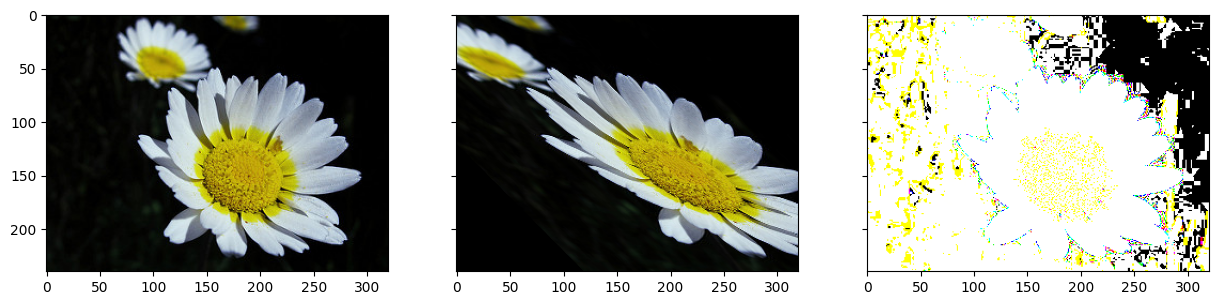

In [26]:
# shear transforms
shear_transforms = transform.AffineTransform(shear=np.deg2rad(45))
shear_matrix = matrix_to_topleft + shear_transforms + matrix_to_center
shear_image = transform.warp(image, shear_matrix)

bright_jitter = image*0.999 + np.zeros_like(image)*0.001

plot_image([image, shear_image, bright_jitter])

## Network Building

In [30]:
from keras.applications import resnet

img_channels = 3
img_rows = 100
img_cols = 100

nb_classes = 2

In [32]:
import tensorflow as tf

In [34]:
class DataGenerator(tf.keras.utils.Sequence):
    'Generates data for Keras'

    def __init__(self, mode='train', ablation=None, flowers_cls=['daisy', 'rose'],
                 batch_size=32, dim=(100, 100), n_channels=3, shuffle=True):
        """
        Initialise the data generator
        """
        self.dim = dim
        self.batch_size = batch_size
        self.labels = {}
        self.list_IDs = []

        # glob through directory of each class
        for i, cls in enumerate(flowers_cls):
            paths = glob.glob(os.path.join(DATASET_PATH, cls, '*'))
            brk_point = int(len(paths)*0.8)
            if mode == 'train':
                paths = paths[:brk_point]
            else:
                paths = paths[brk_point:]
            if ablation is not None:
                paths = paths[:ablation]
            self.list_IDs += paths
            self.labels.update({p:i for p in paths})

        self.n_channels = n_channels
        self.n_classes = len(flowers_cls)
        self.shuffle = shuffle
        self.on_epoch_end()

    def __len__(self):
        'Denotes the number of batches per epoch'
        return int(np.floor(len(self.list_IDs) / self.batch_size))

    def __getitem__(self, index):
        'Generate one batch of data'
        # Generate indexes of the batch
        indexes = self.indexes[index*self.batch_size:(index+1)*self.batch_size]

        # Find list of IDs
        list_IDs_temp = [self.list_IDs[k] for k in indexes]

        # Generate data
        X, y = self.__data_generation(list_IDs_temp)

        return X, y

    def on_epoch_end(self):
        'Updates indexes after each epoch'
        self.indexes = np.arange(len(self.list_IDs))
        if self.shuffle == True:
            np.random.shuffle(self.indexes)

    def __data_generation(self, list_IDs_temp):
        'Generates data containing batch_size samples' # X : (n_samples, *dim, n_channels)
        # Initialization
        X = np.empty((self.batch_size, *self.dim, self.n_channels))
        y = np.empty((self.batch_size), dtype=int)

        delete_rows = []

        # Generate data
        for i, ID in enumerate(list_IDs_temp):
            # Store sample
            img = io.imread(ID)
            img = img/255
            if img.shape[0] > 100 and img.shape[1] > 100:
                h, w, _ = img.shape
                img = img[int(h/2)-50:int(h/2)+50, int(w/2)-50:int(w/2)+50, : ]
            else:
                delete_rows.append(i)
                continue

            X[i,] = img

            # Store class
            y[i] = self.labels[ID]

        X = np.delete(X, delete_rows, axis=0)
        y = np.delete(y, delete_rows, axis=0)
        return X, tf.keras.utils.to_categorical(y, num_classes=self.n_classes)

In [38]:
import six
from tensorflow.keras.models import Model
from tensorflow.keras.layers import (
    Input,
    Activation,
    Dense,
    Flatten,
    add,
    BatchNormalization,
    Conv2D,
    MaxPooling2D,
    AveragePooling2D
)

from tensorflow.keras.regularizers import l2
from tensorflow.keras import backend as K


def _bn_relu(input):
    """Helper to build a BN -> relu block
    """
    norm = BatchNormalization(axis=CHANNEL_AXIS)(input)
    return Activation("relu")(norm)


def _conv_bn_relu(**conv_params):
    """Helper to build a conv -> BN -> relu block
    """
    filters = conv_params["filters"]
    kernel_size = conv_params["kernel_size"]
    strides = conv_params.setdefault("strides", (1, 1))
    kernel_initializer = conv_params.setdefault("kernel_initializer", "he_normal")
    padding = conv_params.setdefault("padding", "same")
    kernel_regularizer = conv_params.setdefault("kernel_regularizer", l2(1.e-4))

    def f(input):
        conv = Conv2D(filters=filters, kernel_size=kernel_size,
                      strides=strides, padding=padding,
                      kernel_initializer=kernel_initializer,
                      kernel_regularizer=kernel_regularizer)(input)
        return _bn_relu(conv)

    return f


def _bn_relu_conv(**conv_params):
    """Helper to build a BN -> relu -> conv block.
    This is an improved scheme proposed in http://arxiv.org/pdf/1603.05027v2.pdf
    """
    filters = conv_params["filters"]
    kernel_size = conv_params["kernel_size"]
    strides = conv_params.setdefault("strides", (1, 1))
    kernel_initializer = conv_params.setdefault("kernel_initializer", "he_normal")
    padding = conv_params.setdefault("padding", "same")
    kernel_regularizer = conv_params.setdefault("kernel_regularizer", l2(1.e-4))

    def f(input):
        activation = _bn_relu(input)
        return Conv2D(filters=filters, kernel_size=kernel_size,
                      strides=strides, padding=padding,
                      kernel_initializer=kernel_initializer,
                      kernel_regularizer=kernel_regularizer)(activation)

    return f


def _shortcut(input, residual):
    """Adds a shortcut between input and residual block and merges them with "sum"
    """
    # Expand channels of shortcut to match residual.
    # Stride appropriately to match residual (width, height)
    # Should be int if network architecture is correctly configured.
    input_shape = K.int_shape(input)
    residual_shape = K.int_shape(residual)
    stride_width = int(round(input_shape[ROW_AXIS] / residual_shape[ROW_AXIS]))
    stride_height = int(round(input_shape[COL_AXIS] / residual_shape[COL_AXIS]))
    equal_channels = input_shape[CHANNEL_AXIS] == residual_shape[CHANNEL_AXIS]

    shortcut = input
    # 1 X 1 conv if shape is different. Else identity.
    if stride_width > 1 or stride_height > 1 or not equal_channels:
        shortcut = Conv2D(filters=residual_shape[CHANNEL_AXIS],
                          kernel_size=(1, 1),
                          strides=(stride_width, stride_height),
                          padding="valid",
                          kernel_initializer="he_normal",
                          kernel_regularizer=l2(0.0001))(input)

    return add([shortcut, residual])


def _residual_block(block_function, filters, repetitions, is_first_layer=False):
    """Builds a residual block with repeating bottleneck blocks.
    """
    def f(input):
        for i in range(repetitions):
            init_strides = (1, 1)
            if i == 0 and not is_first_layer:
                init_strides = (2, 2)
            input = block_function(filters=filters, init_strides=init_strides,
                                   is_first_block_of_first_layer=(is_first_layer and i == 0))(input)
        return input

    return f


def basic_block(filters, init_strides=(1, 1), is_first_block_of_first_layer=False):
    """Basic 3 X 3 convolution blocks for use on resnets with layers <= 34.
    Follows improved proposed scheme in http://arxiv.org/pdf/1603.05027v2.pdf
    """
    def f(input):

        if is_first_block_of_first_layer:
            # don't repeat bn->relu since we just did bn->relu->maxpool
            conv1 = Conv2D(filters=filters, kernel_size=(3, 3),
                           strides=init_strides,
                           padding="same",
                           kernel_initializer="he_normal",
                           kernel_regularizer=l2(1e-4))(input)
        else:
            conv1 = _bn_relu_conv(filters=filters, kernel_size=(3, 3),
                                  strides=init_strides)(input)

        residual = _bn_relu_conv(filters=filters, kernel_size=(3, 3))(conv1)
        return _shortcut(input, residual)

    return f


def bottleneck(filters, init_strides=(1, 1), is_first_block_of_first_layer=False):
    """Bottleneck architecture for > 34 layer resnet.
    Follows improved proposed scheme in http://arxiv.org/pdf/1603.05027v2.pdf
    Returns:
        A final conv layer of filters * 4
    """
    def f(input):

        if is_first_block_of_first_layer:
            # don't repeat bn->relu since we just did bn->relu->maxpool
            conv_1_1 = Conv2D(filters=filters, kernel_size=(1, 1),
                              strides=init_strides,
                              padding="same",
                              kernel_initializer="he_normal",
                              kernel_regularizer=l2(1e-4))(input)
        else:
            conv_1_1 = _bn_relu_conv(filters=filters, kernel_size=(1, 1),
                                     strides=init_strides)(input)

        conv_3_3 = _bn_relu_conv(filters=filters, kernel_size=(3, 3))(conv_1_1)
        residual = _bn_relu_conv(filters=filters * 4, kernel_size=(1, 1))(conv_3_3)
        return _shortcut(input, residual)

    return f


def _handle_dim_ordering():
    global ROW_AXIS
    global COL_AXIS
    global CHANNEL_AXIS
    #if K.image_dim_ordering() == 'tf':
    ROW_AXIS = 1
    COL_AXIS = 2
    CHANNEL_AXIS = 3
    #else:
    #CHANNEL_AXIS = 1
    #ROW_AXIS = 2
    #COL_AXIS = 3


def _get_block(identifier):
    if isinstance(identifier, six.string_types):
        res = globals().get(identifier)
        if not res:
            raise ValueError('Invalid {}'.format(identifier))
        return res
    return identifier


class ResnetBuilder(object):
    @staticmethod
    def build(input_shape, num_outputs, block_fn, repetitions):
        """Builds a custom ResNet like architecture.
        Args:
            input_shape: The input shape in the form (nb_channels, nb_rows, nb_cols)
            num_outputs: The number of outputs at final softmax layer
            block_fn: The block function to use. This is either `basic_block` or `bottleneck`.
                The original paper used basic_block for layers < 50
            repetitions: Number of repetitions of various block units.
                At each block unit, the number of filters are doubled and the input size is halved
        Returns:
            The keras `Model`.
        """
        _handle_dim_ordering()
        if len(input_shape) != 3:
            raise Exception("Input shape should be a tuple (nb_channels, nb_rows, nb_cols)")

        # Permute dimension order if necessary
        # if K.image_dim_ordering() == 'tf':
        input_shape = (input_shape[1], input_shape[2], input_shape[0])

        # Load function from str if needed.
        block_fn = _get_block(block_fn)

        input = Input(shape=input_shape)
        conv1 = _conv_bn_relu(filters=64, kernel_size=(7, 7), strides=(2, 2))(input)
        pool1 = MaxPooling2D(pool_size=(3, 3), strides=(2, 2), padding="same")(conv1)

        block = pool1
        filters = 64
        for i, r in enumerate(repetitions):
            block = _residual_block(block_fn, filters=filters, repetitions=r, is_first_layer=(i == 0))(block)
            filters *= 2

        # Last activation
        block = _bn_relu(block)

        # Classifier block
        block_shape = K.int_shape(block)
        pool2 = AveragePooling2D(pool_size=(block_shape[ROW_AXIS], block_shape[COL_AXIS]),
                                 strides=(1, 1))(block)
        flatten1 = Flatten()(pool2)
        dense = Dense(units=num_outputs, kernel_initializer="he_normal",
                      activation="softmax")(flatten1)

        model = Model(inputs=input, outputs=dense)
        return model

    @staticmethod
    def build_resnet_18(input_shape, num_outputs):
        return ResnetBuilder.build(input_shape, num_outputs, basic_block, [2, 2, 2, 2])

    @staticmethod
    def build_resnet_34(input_shape, num_outputs):
        return ResnetBuilder.build(input_shape, num_outputs, basic_block, [3, 4, 6, 3])

    @staticmethod
    def build_resnet_50(input_shape, num_outputs):
        return ResnetBuilder.build(input_shape, num_outputs, bottleneck, [3, 4, 6, 3])

    @staticmethod
    def build_resnet_101(input_shape, num_outputs):
        return ResnetBuilder.build(input_shape, num_outputs, bottleneck, [3, 4, 23, 3])

    @staticmethod
    def build_resnet_152(input_shape, num_outputs):
        return ResnetBuilder.build(input_shape, num_outputs, bottleneck, [3, 8, 36, 3])

## Running Ablation Experiment

In [40]:
# using resnet 18
model = ResnetBuilder.build_resnet_18((img_channels, img_rows, img_cols), nb_classes)
model.compile(loss='categorical_crossentropy', optimizer='SGD',
              metrics=['accuracy'])

# create data generator objects in train and val mode
# specify ablation=number of data points to train on
training_generator = DataGenerator('train', ablation=100)
validation_generator = DataGenerator('val', ablation=100)

# fit: this will fit the net on 'ablation' samples, only 1 epoch
model.fit(training_generator, epochs=1, validation_data=validation_generator)

/usr/local/lib/python3.10/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:122: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.6115 - loss: 1.6385

/usr/local/lib/python3.10/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:122: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


6/6 ━━━━━━━━━━━━━━━━━━━━ 21s 2s/step - accuracy: 0.6089 - loss: 1.6371 - val_accuracy: 0.5469 - val_loss: 1.8364


In [46]:
from tensorflow.keras import optimizers
from tensorflow.keras.callbacks import *

# range of learning rates to tune
hyper_parameters_for_lr = [0.1, 0.01, 0.001]

# callback to append loss
class LossHistory(tf.keras.callbacks.Callback):
    def on_train_begin(self, logs={}):
        self.losses = []

    def on_epoch_end(self, epoch, logs={}):
        self.losses.append(logs.get('loss'))

# instantiate a LossHistory() object to store histories
history = LossHistory()
plot_data = {}

# for each hyperparam: train the model and plot loss history
for lr in hyper_parameters_for_lr:
    print ('\n\n'+'=='*20 + '   Checking for LR={}  '.format(lr) + '=='*20 )
    sgd = optimizers.SGD(learning_rate=lr, clipnorm=1.)

    # model and generators
    model = ResnetBuilder.build_resnet_18((img_channels, img_rows, img_cols), nb_classes)
    model.compile(loss='categorical_crossentropy',optimizer= sgd,
                  metrics=['accuracy'])
    training_generator = DataGenerator('train', ablation=100)
    validation_generator = DataGenerator('val', ablation=100)
    model.fit(training_generator, epochs=3, validation_data=validation_generator, callbacks=[history])

    # plot loss history
    plot_data[lr] = history.losses



========================================   Checking for LR=0.1  ========================================
Epoch 1/3


/usr/local/lib/python3.10/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:122: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.5408 - loss: 1.7469

/usr/local/lib/python3.10/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:122: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


6/6 ━━━━━━━━━━━━━━━━━━━━ 21s 2s/step - accuracy: 0.5558 - loss: 1.7253 - val_accuracy: 0.5000 - val_loss: 22.0007
Epoch 2/3
6/6 ━━━━━━━━━━━━━━━━━━━━ 11s 2s/step - accuracy: 0.8052 - loss: 1.3904 - val_accuracy: 0.5573 - val_loss: 5.6595
Epoch 3/3
6/6 ━━━━━━━━━━━━━━━━━━━━ 21s 2s/step - accuracy: 0.8645 - loss: 1.2479 - val_accuracy: 0.5104 - val_loss: 8.4602


========================================   Checking for LR=0.01  ========================================
Epoch 1/3


/usr/local/lib/python3.10/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:122: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.4886 - loss: 1.6816

/usr/local/lib/python3.10/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:122: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


6/6 ━━━━━━━━━━━━━━━━━━━━ 20s 2s/step - accuracy: 0.4940 - loss: 1.6784 - val_accuracy: 0.4948 - val_loss: 3.4574
Epoch 2/3
6/6 ━━━━━━━━━━━━━━━━━━━━ 19s 2s/step - accuracy: 0.7187 - loss: 1.5624 - val_accuracy: 0.4948 - val_loss: 3.1524
Epoch 3/3
6/6 ━━━━━━━━━━━━━━━━━━━━ 10s 2s/step - accuracy: 0.7046 - loss: 1.5309 - val_accuracy: 0.5000 - val_loss: 2.7946


========================================   Checking for LR=0.001  ========================================
Epoch 1/3


/usr/local/lib/python3.10/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:122: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.4981 - loss: 1.6932

/usr/local/lib/python3.10/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:122: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


6/6 ━━━━━━━━━━━━━━━━━━━━ 20s 2s/step - accuracy: 0.5021 - loss: 1.6882 - val_accuracy: 0.4844 - val_loss: 2.1609
Epoch 2/3
6/6 ━━━━━━━━━━━━━━━━━━━━ 11s 2s/step - accuracy: 0.5668 - loss: 1.6253 - val_accuracy: 0.4792 - val_loss: 1.9694
Epoch 3/3
6/6 ━━━━━━━━━━━━━━━━━━━━ 11s 2s/step - accuracy: 0.5397 - loss: 1.6366 - val_accuracy: 0.4896 - val_loss: 1.8847


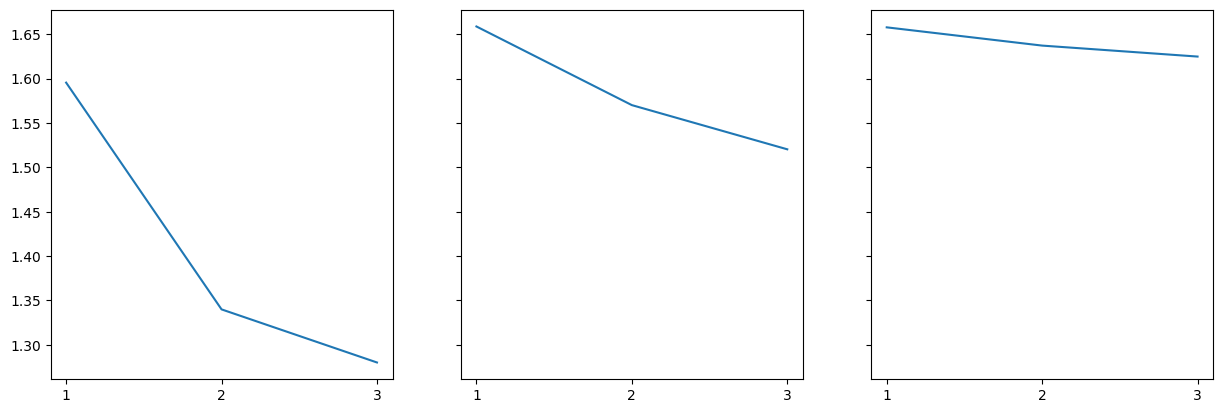

In [47]:
# plot loss history for each value of hyperparameter
f, axes = plt.subplots(1, 3, sharey=True)
f.set_figwidth(15)

plt.setp(axes, xticks=np.arange(0, len(plot_data[0.01]), 1)+1)

for i, lr in enumerate(plot_data.keys()):
    axes[i].plot(np.arange(len(plot_data[lr]))+1, plot_data[lr])

## Decaying LR

In [80]:
import tensorflow as tf
import keras
from keras import optimizers
from keras.callbacks import *

In [84]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import optimizers

# Learning Rate Decay Callback
class DecayLR(keras.callbacks.Callback):
    def __init__(self, base_lr=0.001, decay_epoch=1):
        super(DecayLR, self).__init__()
        self.base_lr = base_lr
        self.decay_epoch = decay_epoch
        self.lr_history = []

    # Set learning rate at the start of training
    def on_train_begin(self, logs=None):
        # Use assign() to update the learning rate
        self.model.optimizer.learning_rate.assign(self.base_lr)
        print("Initial LR:", self.model.optimizer.learning_rate.numpy())

    # Update learning rate at the end of each epoch
    def on_epoch_end(self, epoch, logs=None):
        current_lr = self.model.optimizer.learning_rate.numpy()
        self.lr_history.append(current_lr)
        new_lr = self.base_lr * (0.5 ** (epoch // self.decay_epoch))
        self.model.optimizer.learning_rate.assign(new_lr)
        print(f"Epoch {epoch+1}: Updated LR: {new_lr}")

# Placeholder for LossHistory (assuming it's a custom callback)
class LossHistory(keras.callbacks.Callback):
    def __init__(self):
        super().__init__()
        self.losses = []
    
    def on_epoch_end(self, epoch, logs=None):
        self.losses.append(logs.get('loss'))

# Initialize loss history and plot storage
history = LossHistory()
plot_data = {}

# Start with lr=0.1
decay = DecayLR(base_lr=0.1)
print(type(decay.base_lr))  # Should print: <class 'float'>

# Explicitly set learning rate in the optimizer
sgd = tf.keras.optimizers.SGD(learning_rate=0.1)
model = ResnetBuilder.build_resnet_18((img_channels, img_rows, img_cols), nb_classes)
model.compile(loss='categorical_crossentropy', optimizer=sgd, metrics=['accuracy'])

training_generator = DataGenerator('train', ablation=100)
validation_generator = DataGenerator('val', ablation=100)

model.fit(training_generator, epochs=3, validation_data=validation_generator, callbacks=[history, decay])

# Use a proper key in the dictionary
plot_data["lr"] = decay.lr_history


<class 'float'>
Initial LR: 0.1
Epoch 1/3


/usr/local/lib/python3.10/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:122: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.6665 - loss: 1.5374

/usr/local/lib/python3.10/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:122: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1: Updated LR: 0.1
6/6 ━━━━━━━━━━━━━━━━━━━━ 18s 2s/step - accuracy: 0.6695 - loss: 1.5412 - val_accuracy: 0.4948 - val_loss: 27.5534
Epoch 2/3
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.7551 - loss: 1.6473Epoch 2: Updated LR: 0.05
6/6 ━━━━━━━━━━━━━━━━━━━━ 19s 2s/step - accuracy: 0.7626 - loss: 1.6193 - val_accuracy: 0.5052 - val_loss: 12.6820
Epoch 3/3
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.8915 - loss: 1.2124Epoch 3: Updated LR: 0.025
6/6 ━━━━━━━━━━━━━━━━━━━━ 10s 2s/step - accuracy: 0.8951 - loss: 1.2087 - val_accuracy: 0.5938 - val_loss: 5.4466


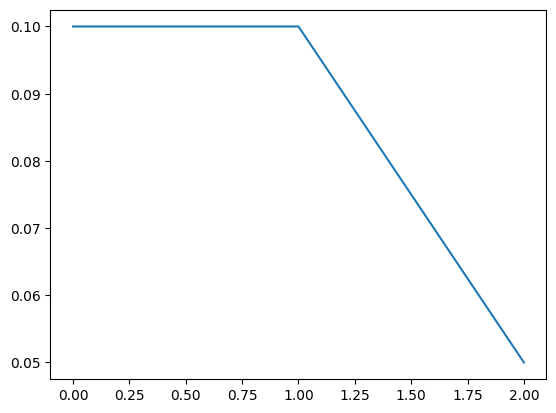

In [85]:
plt.plot(np.arange(len(decay.lr_history)), decay.lr_history)

### Augmentation Technique

In [86]:
# keras data generator
# help(ImageDataGenerator)

from tensorflow.keras.preprocessing.image import ImageDataGenerator
datagen = ImageDataGenerator(
    featurewise_center=True,
    featurewise_std_normalization=True,
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    horizontal_flip=True)

In [87]:
import numpy as np
import tensorflow as tf

# data generator with augmentation
class AugmentedDataGenerator(tf.keras.utils.Sequence):
    'Generates data for Keras'
    def __init__(self, mode='train', ablation=None, flowers_cls=['daisy', 'rose'],
                 batch_size=32, dim=(100, 100), n_channels=3, shuffle=True):
        'Initialization'
        self.dim = dim
        self.batch_size = batch_size
        self.labels = {}
        self.list_IDs = []
        self.mode = mode

        for i, cls in enumerate(flowers_cls):
            paths = glob.glob(os.path.join(DATASET_PATH, cls, '*'))
            brk_point = int(len(paths)*0.8)
            if self.mode == 'train':
                paths = paths[:brk_point]
            else:
                paths = paths[brk_point:]
            if ablation is not None:
                paths = paths[:ablation]
            self.list_IDs += paths
            self.labels.update({p:i for p in paths})


        self.n_channels = n_channels
        self.n_classes = len(flowers_cls)
        self.shuffle = shuffle
        self.on_epoch_end()

    def __len__(self):
        'Denotes the number of batches per epoch'
        return int(np.floor(len(self.list_IDs) / self.batch_size))

    def __getitem__(self, index):
        'Generate one batch of data'
        # Generate indexes of the batch
        indexes = self.indexes[index*self.batch_size:(index+1)*self.batch_size]

        # Find list of IDs
        list_IDs_temp = [self.list_IDs[k] for k in indexes]

        # Generate data
        X, y = self.__data_generation(list_IDs_temp)

        return X, y

    def on_epoch_end(self):
        'Updates indexes after each epoch'
        self.indexes = np.arange(len(self.list_IDs))
        if self.shuffle == True:
            np.random.shuffle(self.indexes)

    def __data_generation(self, list_IDs_temp):
        'Generates data containing batch_size samples' # X : (n_samples, *dim, n_channels)
        # Initialization
        X = np.empty((self.batch_size, *self.dim, self.n_channels))
        y = np.empty((self.batch_size), dtype=int)

        delete_rows = []

        # Generate data
        for i, ID in enumerate(list_IDs_temp):
            # Store sample
            img = io.imread(ID)
            img = img/255
            if img.shape[0] > 100 and img.shape[1] > 100:
                h, w, _ = img.shape
                img = img[int(h/2)-50:int(h/2)+50, int(w/2)-50:int(w/2)+50, : ]
            else:
                delete_rows.append(i)
                continue

            X[i,] = img

            # Store class
            y[i] = self.labels[ID]

        X = np.delete(X, delete_rows, axis=0)
        y = np.delete(y, delete_rows, axis=0)

        # data augmentation
        if self.mode == 'train':
            aug_x = np.stack([datagen.random_transform(img) for img in X])
            X = np.concatenate([X, aug_x])
            y = np.concatenate([y, y])
        return X, tf.keras.utils.to_categorical(y, num_classes=self.n_classes)

In [88]:
from sklearn.metrics import roc_auc_score

class roc_callback(Callback):

    def on_train_begin(self, logs={}):
        logs['val_auc'] = 0

    def on_epoch_end(self, epoch, logs={}):
        y_p = []
        y_v = []
        for i in range(len(validation_generator)):
            x_val, y_val = validation_generator[i]
            y_pred = self.model.predict(x_val)
            y_p.append(y_pred)
            y_v.append(y_val)
        y_p = np.concatenate(y_p)
        y_v = np.concatenate(y_v)
        roc_auc = roc_auc_score(y_v, y_p)
        print ('\nVal AUC for epoch{}: {}'.format(epoch, roc_auc))
        logs['val_auc'] = roc_auc

### Final Run

In [94]:
# model
model = ResnetBuilder.build_resnet_18((img_channels, img_rows, img_cols), nb_classes)
sgd = tf.keras.optimizers.SGD(learning_rate=0.1)
model.compile(loss='categorical_crossentropy',optimizer= sgd,
              metrics=['accuracy'])
training_generator = AugmentedDataGenerator('train', ablation=32)
validation_generator = AugmentedDataGenerator('val', ablation=32)



# checkpoint
filepath = 'models/best_model.keras'
checkpoint = ModelCheckpoint(filepath, monitor='val_auc', verbose=1, save_best_only=True, mode='max')
auc_logger = roc_callback()

# fit
model.fit(training_generator, epochs=3, validation_data=validation_generator, callbacks=[auc_logger, history, decay, checkpoint])

Initial LR: 0.1
Epoch 1/3


/usr/local/lib/python3.10/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:122: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 3s/step - accuracy: 0.5312 - loss: 1.8264 

/usr/local/lib/python3.10/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:122: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 890ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 288ms/step

Val AUC for epoch0: 0.580078125
Epoch 1: Updated LR: 0.1

Epoch 1: val_auc improved from -inf to 0.58008, saving model to models/best_model.keras
2/2 ━━━━━━━━━━━━━━━━━━━━ 16s 7s/step - accuracy: 0.5312 - loss: 1.8303 - val_accuracy: 0.5000 - val_loss: 22.5062 - val_auc: 0.5801
Epoch 2/3
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 289ms/stepaccuracy: 0.5664 - loss: 2.00
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 290ms/step

Val AUC for epoch1: 0.673828125
Epoch 2: Updated LR: 0.05

Epoch 2: val_auc improved from 0.58008 to 0.67383, saving model to models/best_model.keras
2/2 ━━━━━━━━━━━━━━━━━━━━ 8s 5s/step - accuracy: 0.5729 - loss: 1.9703 - val_accuracy: 0.5156 - val_loss: 12.5421 - val_auc: 0.6738
Epoch 3/3
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 293ms/stepaccuracy: 0.7461 - loss: 1.44
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 293ms/step

Val AUC for epoch2: 0.7138671875
Epoch 3: Updated LR: 0.025

Epoch 3: val_auc improved from 0.67383 to 0.71387, saving model t

In [ ]:
plt.imshow(image)

In [98]:
h, w, _ = image.shape
img = image[int(h/2)-50:int(h/2)+50, int(w/2)-50:int(w/2)+50, : ]

model.predict(img[np.newaxis,: ])

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 631ms/step


array([[1., 0.]], dtype=float32)